© Copyright 2019, Kevin Sheppard

© Copyright 2019, Dataiku

# Financial Modeling Tutorial


One of the limiting hypothesis of many autoregressive models for univariate time series data (such as AR, ARIMA, SARIMA) is that of constant variance over time. In the finance industry, this change of variance is often referred to as volatility.  

When the volatility is correlated over time, this can be modeled using processes from the ARCH family. Another indicator that ARCH techniques might be well suited is when your current model's error is facing heteroskedasticity, i.e. the error variance is not constant over time.  

Here will leverage the `arch` python library and we'll follow this [tutorial](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html). 

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use.


In [1]:
from statsmodels.graphics.tsaplots import plot_acf

import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

from arch import arch_model
from arch.data import sp500

%matplotlib inline

For illustrations purposes, we'll use the SP500 dataset.

In [2]:
data = sp500.load()
market = data['Adj Close']
returns = 100 * market.pct_change().dropna()

First, and as always, we plot the time series of returns.

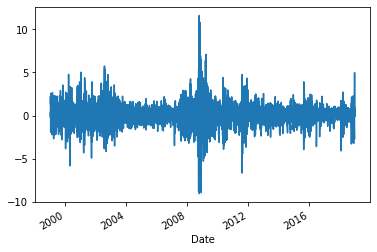

In [3]:
returns.plot()

We now look at the autocorrelation of the variance of that time series. 

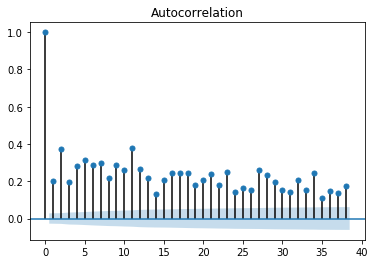

In [4]:
plot_acf(returns**2-returns.mean())
pyplot.show()

We see significant positive correlation in variance !

## Basic Forecasting

Forecasts can be generated for standard GARCH(p,q) processes using any of the three forecast generation methods:

    Analytical
    Simulation-based
    Bootstrap-based

Be default forecasts will only be produced for the final observation in the sample so that they are out-of-sample.

Forecasts start with specifying the model and estimating parameters.

In [5]:
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6942.15956734673
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6936.71853003242
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6936.718476989003
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11


In [6]:
forecasts = res.forecast()

The default forecast only produces 1-step ahead forecasts.

In [7]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
Date                
2018-12-27       NaN
2018-12-28       NaN
2018-12-31  0.056353
                h.1
Date               
2018-12-27      NaN
2018-12-28      NaN
2018-12-31  3.59647
                h.1
Date               
2018-12-27      NaN
2018-12-28      NaN
2018-12-31  3.59647


Longer horizon forecasts can be computed by passing the parameter horizon.

In [8]:
forecasts = res.forecast(horizon=5)
print(forecasts.residual_variance.iloc[-3:])

                h.1       h.2       h.3       h.4       h.5
Date                                                       
2018-12-27      NaN       NaN       NaN       NaN       NaN
2018-12-28      NaN       NaN       NaN       NaN       NaN
2018-12-31  3.59647  3.568502  3.540887  3.513621  3.486701


### TARCH: Analytical Forecasts

All ARCH-type models have one-step analytical forecasts. Longer horizons only have closed forms for specific models. TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required. Attempting to produce forecasts for horizons larger than 1 using `method='analytical'` results in a `ValueError`.

In [9]:
# TARCH specification
am = arch_model(returns, vol='GARCH', power=2.0, p=1, o=1, q=1)
res = am.fit(update_freq=5)
forecasts = res.forecast()
print(forecasts.variance.iloc[-1])

Iteration:      5,   Func. Count:     44,   Neg. LLF: 6827.96641441215
Iteration:     10,   Func. Count:     84,   Neg. LLF: 6822.8830945206155
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6822.882823359995
            Iterations: 13
            Function evaluations: 106
            Gradient evaluations: 13
h.1    3.010188
Name: 2018-12-31 00:00:00, dtype: float64


### Simulation Forecasts

(735967.0, 736328.0)

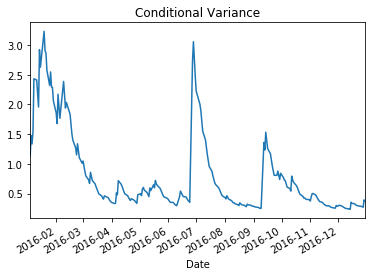

In [10]:
 var_2016 = res.conditional_volatility['2016']**2.0
subplot = var_2016.plot(title='Conditional Variance')
subplot.set_xlim(var_2016.index[0], var_2016.index[-1])

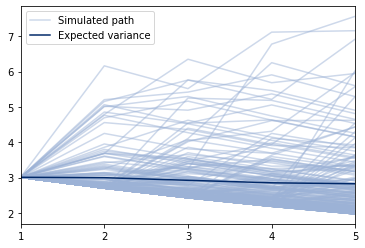

In [11]:
forecasts = res.forecast(horizon=5, method='simulation')
sims = forecasts.simulations

x = np.arange(1, 6)
lines = pyplot.plot(x, sims.residual_variances[-1, ::5].T, color='#9cb2d6', alpha=0.5)
lines[0].set_label('Simulated path')
line = pyplot.plot(x, forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
pyplot.gca().set_xticks(x)
pyplot.gca().set_xlim(1,5)
legend = pyplot.legend()

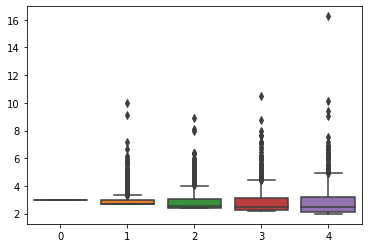

In [12]:
sns.boxplot(data=sims.variances[-1])